<a href="https://colab.research.google.com/github/FelicieDh/FishMapping/blob/main/GaussianProcessFish_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.animation import PillowWriter
rc('animation', html='jshtml')

Here we go

In [4]:
df = pd.read_csv("2408_GPdata_nozero.csv")
df.head()

,compID,sonar,E_cent_utm,N_cent_utm,datetime,sec
0,Sompalampi15am,black,629382.470498,6.945809e+06,2024-03-15T07:46:00Z,38
1,Sompalampi15am,black,629381.783552,6.945814e+06,2024-03-15T07:46:00Z,38
2,Sompalampi15am,black,629378.787054,6.945813e+06,2024-03-15T07:46:00Z,38
3,Sompalampi15am,black,629380.357410,6.945808e+06,2024-03-15T07:46:00Z,38
4,Sompalampi15am,black,629381.883417,6.945812e+06,2024-03-15T07:46:00Z,38


In [5]:
df['min'] = df['sec'] / 60

I need to train and save a model for each competitions

In [16]:
for i in range(0,len(np.unique(df.compID))):
    X_train = df[df.compID == np.unique(df.compID)[i]][['E_cent_utm', 'N_cent_utm', 'min']]
    y_train = np.ones((df[df.compID == np.unique(df.compID)[i]].shape[0]))

    kernel = 1 * RBF(length_scale=3.0, length_scale_bounds="fixed") # (1e-2, 1e2)
    gaussian_process = GaussianProcessRegressor(kernel=kernel)
    gaussian_process.fit(X_train.values, y_train)


# save the iris classification model as a pickle file
    model_pkl_file = "Model_no0_" + np.unique(df.compID)[i] +".pkl"

    with open(model_pkl_file, 'wb') as file:
        pickle.dump(gaussian_process, file)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Now I need to iteratively save dictionaries

In [17]:
extents = pd.read_csv("2408_ArenaExtents.csv")
extents.head()

,compID,xmin,xmax,ymin,ymax,xpink,ypink,xyellow,yyellow,xblack,yblack,xmin.cor,ymin.cor,xmax.cor,ymax.cor
0,Sompalampi15am,629290.042484,629413.106465,6.945723e+06,6.945854e+06,629330.042484,6.945790e+06,629373.106465,6.945763e+06,629372.887593,6.945814e+06,629290,6945723,629425,6945858
1,Sompalampi15pm,629506.239314,629636.246795,6.945755e+06,6.945879e+06,629596.246795,6.945839e+06,629546.239314,6.945838e+06,629571.417931,6.945795e+06,629506,6945755,629641,6945890
2,Sompalampi18am,629420.302505,629548.571789,6.945687e+06,6.945813e+06,629460.302505,6.945727e+06,629508.571789,6.945727e+06,629482.305482,6.945773e+06,629420,6945687,629555,6945822
3,Sompalampi18pm,629531.216417,629655.246200,6.945879e+06,6.946013e+06,629615.246200,6.945973e+06,629571.216417,6.945948e+06,629612.782369,6.945919e+06,629531,6945879,629666,6946014
4,Kuorinka19am,622580.652627,622709.042456,6.942661e+06,6.942789e+06,622620.652627,6.942701e+06,622669.042456,6.942710e+06,622637.096363,6.942749e+06,622581,6942661,622716,6942796


In [ ]:
for i in range(0,len(np.unique(df.compID))):

    model_pkl_file = "Model_no0_" + np.unique(df.compID)[i] +".pkl"

    with open(model_pkl_file, 'rb') as file:
        gaussian_process = pickle.load(file)


    x = np.linspace(extents[extents.compID == np.unique(df.compID)[i]]['xmin.cor'].iloc[0],
                 extents[extents.compID == np.unique(df.compID)[i]]['xmax.cor'].iloc[0],
                 135)

    y = np.linspace(extents[extents.compID == np.unique(df.compID)[i]]['ymin.cor'].iloc[0],
                 extents[extents.compID == np.unique(df.compID)[i]]['ymax.cor'].iloc[0],
                 135)

    xx, yy = np.meshgrid(x, y)


    csr_matrices = {}

    for t in range(1,int(round(max(df[df.compID == np.unique(df.compID)[i]]['min']),0))):
      X = np.hstack([np.vstack((xx.ravel(), yy.ravel())).T, np.ones((18225, 1)) * t])
      mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
      csr_matrices[t] = mean_prediction.reshape(xx.shape)


    predict_pkl_file = "Predict_no0_" + np.unique(df.compID)[i] +".pkl"

    with open(predict_pkl_file, 'wb') as file:
      pickle.dump(csr_matrices, file)

<ipython-input-118-590ed2f8d2f6>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


<Figure size 640x480 with 0 Axes>

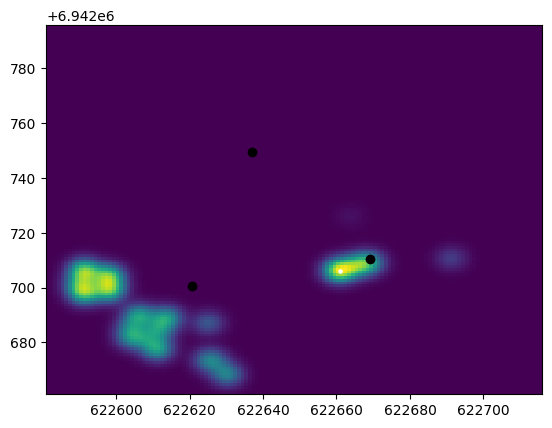

<Figure size 640x480 with 0 Axes>

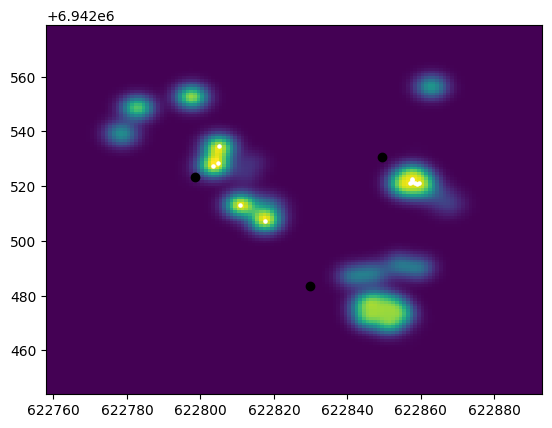

<Figure size 640x480 with 0 Axes>

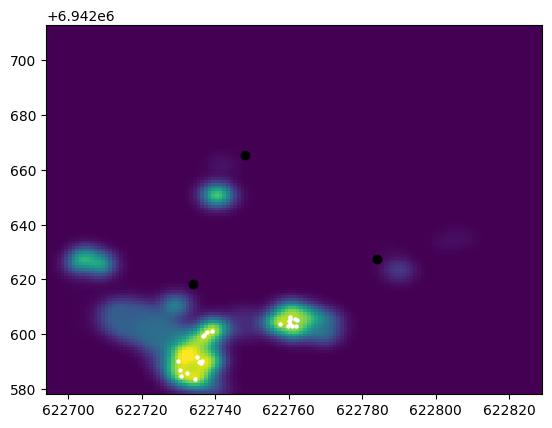

<Figure size 640x480 with 0 Axes>

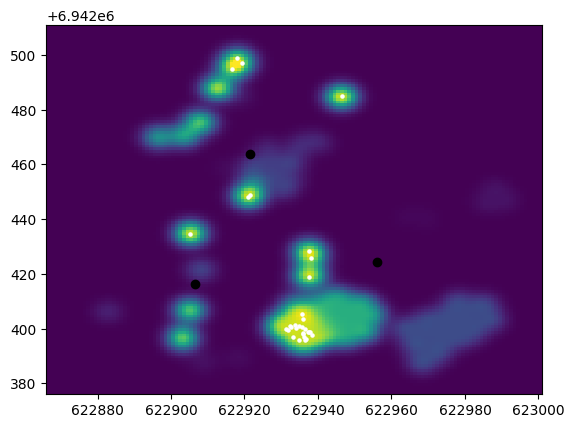

<Figure size 640x480 with 0 Axes>

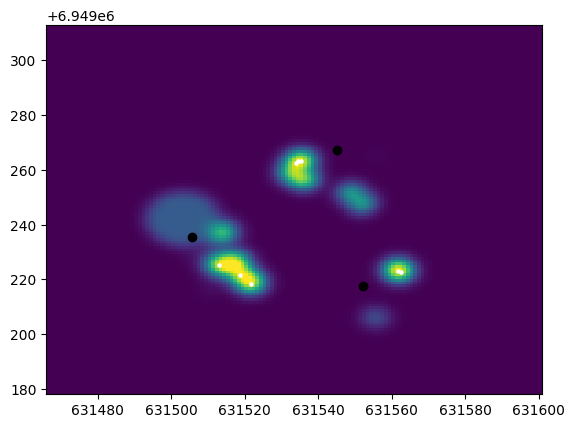

<Figure size 640x480 with 0 Axes>

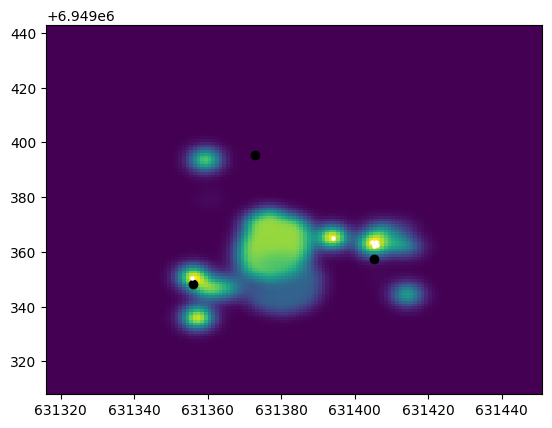

<Figure size 640x480 with 0 Axes>

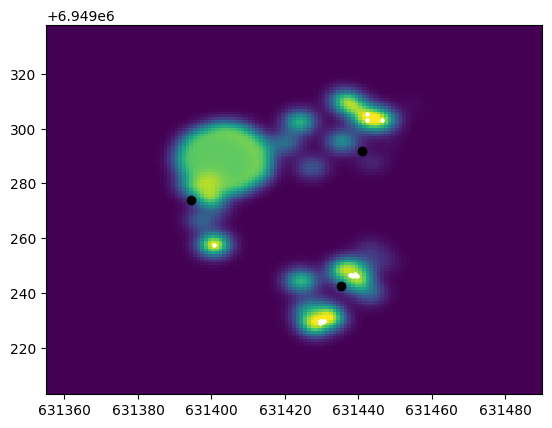

<Figure size 640x480 with 0 Axes>

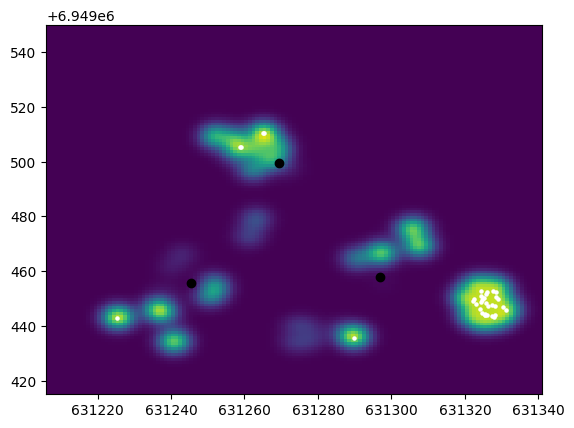

<Figure size 640x480 with 0 Axes>

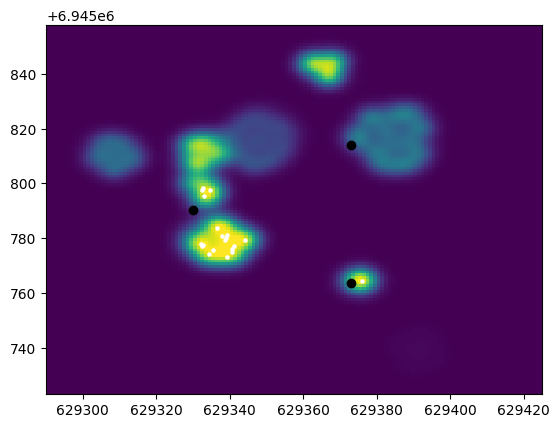

<Figure size 640x480 with 0 Axes>

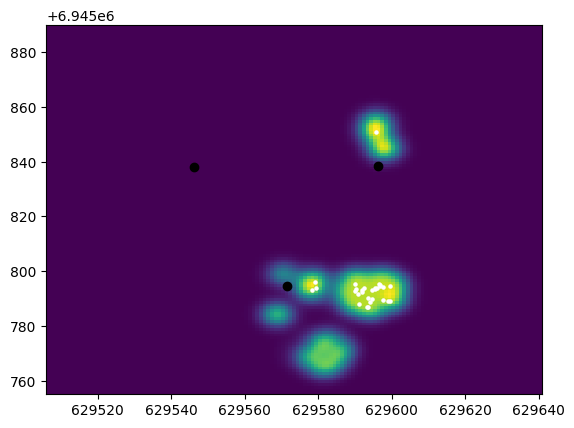

<Figure size 640x480 with 0 Axes>

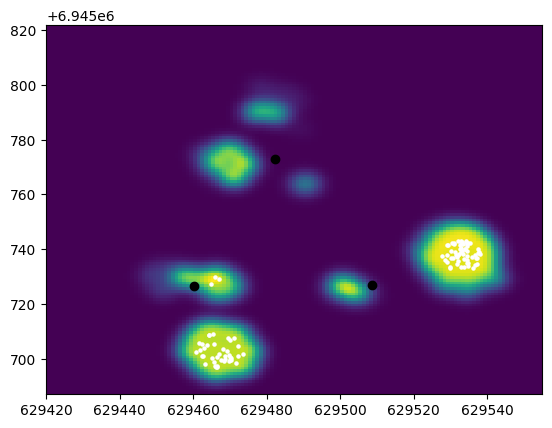

<Figure size 640x480 with 0 Axes>

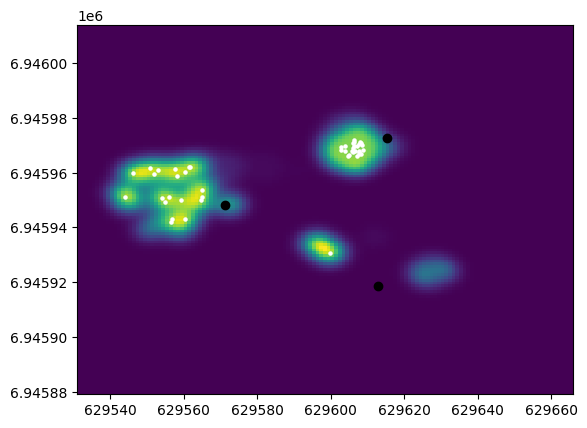

In [ ]:
for i in range(0,len(np.unique(df.compID))):
    predict_pkl_file = "Predict_no0_" + np.unique(df.compID)[i] +".pkl"

    with open(predict_pkl_file, 'rb') as file:
        csr_matrices = pickle.load(file)

    fig = plt.figure()
    fig, ax = plt.subplots()
    im = plt.imshow(
        csr_matrices[1],
        interpolation="nearest",
        extent=(extents[extents.compID == np.unique(df.compID)[i]]['xmin.cor'].iloc[0],
                extents[extents.compID == np.unique(df.compID)[i]]['xmax.cor'].iloc[0],
                extents[extents.compID == np.unique(df.compID)[i]]['ymin.cor'].iloc[0],
                extents[extents.compID == np.unique(df.compID)[i]]['ymax.cor'].iloc[0]),
        aspect=1,
        origin="lower"
    )

    plt.scatter(extents[extents.compID == np.unique(df.compID)[i]]['xpink'].iloc[0], extents[extents.compID == np.unique(df.compID)[i]]['ypink'].iloc[0], color = 'black')
    plt.scatter(extents[extents.compID == np.unique(df.compID)[i]]['xyellow'].iloc[0], extents[extents.compID == np.unique(df.compID)[i]]['yyellow'].iloc[0], color = 'black')
    plt.scatter(extents[extents.compID == np.unique(df.compID)[i]]['xblack'].iloc[0], extents[extents.compID == np.unique(df.compID)[i]]['yblack'].iloc[0], color = 'black')



    fish = ax.scatter(df[(df.compID == np.unique(df.compID)[i]) & (df['min'] > 0-1) & (df['min'] < 0+1)]["E_cent_utm"] ,
                 df[(df.compID == np.unique(df.compID)[i]) & (df['min'] > 0-1) & (df['min'] < 0+1)]["N_cent_utm"] ,
                 color = 'white', s=5)

#def init():
#    im.set_data(csr_matrices[1])
    num_frames = len(csr_matrices)

    def animate(k):
        k = min(k, num_frames)
        im.set_data(csr_matrices[k])
        fish_positions = df[(df.compID == np.unique(df.compID)[i]) & (df['min'] > k-1) & (df['min'] < k+1)][["E_cent_utm", "N_cent_utm"]].values
        fish.set_offsets(fish_positions) # Pass the combined array to set_offsets
        return im

    anim = animation.FuncAnimation(fig, animate, frames=range(1,120), interval=500)

    mywriter = animation.FFMpegWriter(fps=2)

    anim_name = "GIF_no0_" + np.unique(df.compID)[i] +".mp4"
    anim.save(anim_name,writer=mywriter, dpi=300)
    del(im)
    del(fish)
    del(anim)
